## 03. Results Analysis

In [1]:
# Библиотеки
import import_ipynb
from ml_utils import plot_predicted_vs_true

from config import PROCESSED_CSV_PATH, RESULTS_DIR, CENTROIDS_CSV_PATH

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML
from IPython.display import display


from shapely.ops import transform
from shapely import wkt
from pyproj import Geod
# Карта   
import folium
from folium import Figure
from folium.plugins import MarkerCluster
from shapely.geometry import Polygon, mapping



number,vertex_id,sc63_x,sc63_y,wgs84_lon,wgs84_lat,wgs84_baseline_lat,wgs84_baseline_lon,zone,delta_lon_from_baseline,delta_lat_from_baseline
1821784000:01:000:0047,0,3192877.82,5618902.39,27.979588,50.773555,50.773602,27.979662,3.0,0.000074,0.000048
1821784000:01:000:0047,1,3192922.16,5618900.40,27.980217,50.773546,50.773593,27.980291,3.0,0.000074,0.000047
1821784000:01:000:0047,2,3192997.50,5618818.83,27.981308,50.772825,50.772874,27.981383,3.0,0.000074,0.000049
1821784000:01:000:0047,3,3192928.48,5618769.62,27.980343,50.772370,50.772419,27.980419,3.0,0.000076,0.000049
1821784000:01:000:0047,4,3192907.25,5618764.09,27.980046,50.772316,50.772365,27.980120,3.0,0.000073,0.000049
1821784000:01:000:0047,5,3192921.28,5618738.93,27.980253,50.772095,50.772142,27.980326,3.0,0.000073,0.000047
1821784000:01:000:0047,6,3192936.63,5618747.73,27.980468,50.772177,50.772224,27.980541,3.0,0.000072,0.000046
1821784000:01:000:0047,7,3192928.48,5618769.62,27.980343,50.772370,50.772419,27.980419,3.0,0.000076,0.000049
1821784000:01:000:0047,8,3192997.50,5618818.83,27.981308,50.772825,50.772874,27.981383,3.0,0.000074,0.000049
1821784000:01:000:0047,9,3192986.46,5618669.54,27.981196,50.771481,50.771530,27.981270,3.0,0.000074,0.000049


true_lon,true_lat,pred_lon,pred_lat,sc63_x,sc63_y,number,vertex_id,err_lon,err_lat,err_dist_deg,err_lon_m,err_lat_m,err_dist_m,model


<string>:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


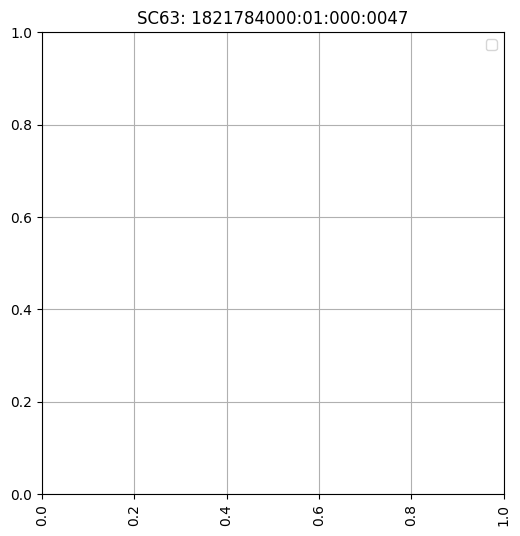

In [2]:
# наши "монстры": 1821784000:01:000:0047, 4623388000:07:000:0014, 5924187900:04:002:0261

number = "1821784000:01:000:0047"  # Замените на нужный номер участка

df_points = pd.read_csv(PROCESSED_CSV_PATH)
df_hgb = pd.read_csv(RESULTS_DIR+"predictions_HGB_v3.0.csv")

display(HTML(df_points[df_points["number"] == number].to_html(index=False)))
display(HTML(df_hgb[df_hgb["number"] == number].to_html(index=False)))

plot_predicted_vs_true(df_points, df_hgb, number)

In [2]:
def build_polygon_dataframe(df_points):
    """
    Строит обычный DataFrame с полигонами (shapely.Polygon), сгруппированными по 'number'.
    """
    records = []

    for number, group in df_points.groupby("number"):
        coords = group.sort_values(by="vertex_id")[["wgs84_lon", "wgs84_lat"]].values
        if len(coords) >= 3:
            polygon = Polygon(coords)
            records.append({"number": number, "geometry": polygon})
        else:
            print(f"Warning: участок {number} содержит менее 3 точек и пропущен")

    return pd.DataFrame(records)


def shift_polygon_to_new_centroid(polygon, new_centroid):
    """
    Смещает полигон к новому центроиду, сохраняя форму и ориентацию.
    """
    old_centroid = polygon.centroid
    dx = new_centroid[0] - old_centroid.x
    dy = new_centroid[1] - old_centroid.y
    shifted_coords = [(x + dx, y + dy) for x, y in polygon.exterior.coords]
    return Polygon(shifted_coords)


def visualize_polygons_on_map(df_polygons, df_predictions, save_path="polygon_map.html"):
    """
    Визуализирует базовые и предсказанные полигоны с соединяющей линией между центрами.
    """
    # Центр карты по средним координатам всех центроидов
    centroids = df_polygons["geometry"].apply(lambda p: p.centroid)
    center_lat = centroids.apply(lambda p: p.y).mean()
    center_lon = centroids.apply(lambda p: p.x).mean()

    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    cluster = MarkerCluster().add_to(m)

    merged = df_polygons.merge(df_predictions, on="number", how="inner")

    for _, row in merged.iterrows():
        poly = row["geometry"]
        centroid = poly.centroid
        pred_point = [row["pred_lat"], row["pred_lon"]]

        # Базовый полигон (синий)
        folium.GeoJson(mapping(poly), tooltip=f"№ {row['number']}", style_function=lambda x: {"color": "blue"}).add_to(cluster)

        # Предсказанный полигон (красный, смещённый)
        pred_polygon = shift_polygon_to_new_centroid(poly, (row["pred_lon"], row["pred_lat"]))
        folium.GeoJson(mapping(pred_polygon), style_function=lambda x: {"color": "red", "weight": 2, "fillOpacity": 0}).add_to(cluster)

        # Синий маркер — настоящий центр
        folium.CircleMarker(
            location=[centroid.y, centroid.x],
            radius=5,
            color="blue",
            fill=True,
            fill_opacity=0.7,
            tooltip="Базовый центр"
        ).add_to(cluster)

        # Красный маркер — предсказанный центр
        folium.CircleMarker(
            location=pred_point,
            radius=5,
            color="red",
            fill=True,
            fill_opacity=0.7,
            tooltip=f"Предсказание\nОшибка: {row['err_dist_m']:.2f} м"
        ).add_to(cluster)

        # Линия между центрами
        folium.PolyLine(
            locations=[ [centroid.y, centroid.x], pred_point ],
            color="orange",
            weight=2,
            opacity=0.7
        ).add_to(cluster)

    m.save(save_path)
    print(f"Карта сохранена в {save_path}")


# Загрузка данных
df_predictions = pd.read_csv(RESULTS_DIR + "predictions_LR_v2c.0.csv")
df_centroids = pd.read_csv(CENTROIDS_CSV_PATH)
df_points = pd.read_csv(PROCESSED_CSV_PATH)

# Построение DataFrame с полигонами
df_polygons = build_polygon_dataframe(df_points)

# Визуализация на карте
visualize_polygons_on_map(df_polygons, df_predictions, save_path=RESULTS_DIR + "polygon_map.html")


Карта сохранена в ./mnt/results/polygon_map.html


In [8]:
geod = Geod(ellps="WGS84")

def polygon_area_m2(poly):
    """Площадь полигона в метрах по координатам WGS84"""
    lons, lats = zip(*poly)
    area, _ = geod.polygon_area_perimeter(lons, lats)
    return abs(area)

def polygon_intersection_area(p1, p2):
    poly1 = Polygon(p1)
    poly2 = Polygon(p2)
    if not poly1.is_valid or not poly2.is_valid:
        return 0
    inter = poly1.intersection(poly2)
    if inter.is_empty:
        return 0
    return polygon_area_m2(list(inter.exterior.coords))

def haversine(lat1, lon1, lat2, lon2):
    _, _, dist = geod.inv(lon1, lat1, lon2, lat2)
    return dist

def plot_polygon_centroid_shift(number, df_predictions, df_centroids, df_points):
    """
    Визуализирует сдвиг полигона по номеру и выводит аналитику:
    - Истинный полигон
    - По baseline центроиду
    - По предсказанному центроиду
    """
    # Истинный полигон
    poly_true = df_points[df_points["number"] == number][["wgs84_lat", "wgs84_lon"]].values.tolist()
    if len(poly_true) < 3:
        print("Недостаточно точек")
        return

    # Центроиды
    true_centroid = df_centroids[df_centroids["number"] == number][["wgs84_centroid_lon", "wgs84_centroid_lat"]].values[0]
    baseline_centroid = df_centroids[df_centroids["number"] == number][["wgs84_centroid_baseline_lon", "wgs84_centroid_baseline_lat"]].values[0]
    delta_pred = df_predictions[df_predictions["number"] == number][["pred_delta_lon_from_baseline", "pred_delta_lat_from_baseline"]].values[0]
    pred_centroid = (
        baseline_centroid[0] + delta_pred[0],
        baseline_centroid[1] + delta_pred[1]
    )

    # Смещение
    dx_pred = pred_centroid[0] - baseline_centroid[0]
    dy_pred = pred_centroid[1] - baseline_centroid[1]

    dx_base = baseline_centroid[0] - true_centroid[0]
    dy_base = baseline_centroid[1] - true_centroid[1]

    poly_baseline = [[lat + dy_base, lon + dx_base] for lat, lon in poly_true]
    poly_shifted = [[lat - dy_pred + dy_base, lon - dx_pred + dx_base] for lat, lon in poly_true]


    fig = Figure(width=1200, height=600)
    m = folium.Map(location=[true_centroid[1], true_centroid[0]], zoom_start=16)
    fig.add_child(m)    #  

    folium.Polygon(
        poly_true, 
        color="green", 
        weight=2,
        opacity=0.5,
        fill=True, 
        fill_color="green",
        fill_opacity=0.4,
        tooltip="Истинный"
    ).add_to(m)

    folium.Polygon(
        poly_baseline, 
        color="red", 
        weight=2,
        opacity=0.3,
        fill=True, 
        fill_color="red",
        fill_opacity=0.2,
        tooltip="Baseline"
    ).add_to(m)

    folium.Polygon(
        poly_shifted, 
        color="blue", 
        weight=2,
        opacity=0.3,
        fill=False, 
        fill_color="blue",
        fill_opacity=0.2,
        tooltip="Предсказанный"
    ).add_to(m)

    folium.Marker([true_centroid[1], true_centroid[0]], tooltip="Истинный центр", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker([baseline_centroid[1], baseline_centroid[0]], tooltip="Baseline", icon=folium.Icon(color="red")).add_to(m)
    folium.Marker([pred_centroid[1], pred_centroid[0]], tooltip="Предсказанный", icon=folium.Icon(color="blue")).add_to(m)

    # Аналитика
    dist_base = haversine(*true_centroid[::-1], *baseline_centroid[::-1])
    dist_pred = haversine(*true_centroid[::-1], *pred_centroid[::-1])

    area_true = polygon_area_m2(poly_true)
    area_base = polygon_area_m2(poly_baseline)
    area_pred = polygon_area_m2(poly_shifted)

    inter_base = polygon_intersection_area(poly_true, poly_baseline)
    inter_pred = polygon_intersection_area(poly_true, poly_shifted)

    pct_base = round(inter_base / area_true * 100, 2)
    pct_pred = round(inter_pred / area_true * 100, 2)

    data = {
        "Metric": [
            "Distance to baseline center (m)",
            "Distance to predicted center (m)",
            "True polygon area (m²)",
            "Overlap with baseline (%)",
            "Overlap with prediction (%)"
        ],
        "Значение": [
            round(dist_base, 2),
            round(dist_pred, 2),
            round(area_true, 2),
            pct_base,
            pct_pred
        ]
    }

    df_ = pd.DataFrame(data)
    display(HTML("<h4>📊 Field-level analysis</h4>"))
    display(HTML(df_.to_html(index=False)))

    return m


In [9]:
df_predictions = pd.read_csv(RESULTS_DIR+f"predictions_RANSAC_v2c.0.csv")
df_centroids = pd.read_csv(CENTROIDS_CSV_PATH)
df_points = pd.read_csv(PROCESSED_CSV_PATH)
df_predictions = df_predictions.merge(
    df_centroids[["number", "wgs84_centroid_baseline_lon", "wgs84_centroid_baseline_lat"]],
    on="number",
    how="left"
)

plot_polygon_centroid_shift(
    number="1220385500:03:007:0164",
    df_centroids=df_centroids,
    df_predictions=df_predictions,
    df_points=df_points
)


Metric,Значение
Distance to baseline center (m),5.05
Distance to predicted center (m),10.26
True polygon area (m²),3060.68
Overlap with baseline (%),86.11
Overlap with prediction (%),99.37


In [37]:
from shapely.geometry import Polygon
from shapely.affinity import translate
import matplotlib.pyplot as plt

def plot_polygon_comparison(number, df_points, df_predictions):
    """
    Визуализирует три полигона по номеру участка:
    - Истинный
    - С baseline центроидом
    - С предсказанным центроидом
    """

    # 1. Получаем точки полигона
    poly_df = df_points[df_points["number"] == number]
    coords_true = list(zip(poly_df["wgs84_lon"], poly_df["wgs84_lat"]))
    poly_true = Polygon(coords_true)

    # 2. Центроиды
    row_pred = df_predictions[df_predictions["number"] == number].iloc[0]
    centroid_true = poly_true.centroid

    # Предполагается, что модель предсказывает дельту (сдвиг от baseline)
    baseline_x = row_pred["pred_lon"] - row_pred["pred_delta_lon_from_baseline"]
    baseline_y = row_pred["pred_lat"] - row_pred["pred_delta_lat_from_baseline"]

    dx_baseline = baseline_x - centroid_true.x
    dy_baseline = baseline_y - centroid_true.y
    dx_pred = row_pred["pred_lon"] - centroid_true.x
    dy_pred = row_pred["pred_lat"] - centroid_true.y

    poly_baseline = translate(poly_true, xoff=dx_baseline, yoff=dy_baseline)
    poly_predicted = translate(poly_true, xoff=dx_pred, yoff=dy_pred)

    # 3. Визуализация
    fig, ax = plt.subplots(figsize=(8, 8))
    for poly, color, label in zip(
        [poly_true, poly_baseline, poly_predicted],
        ["green", "orange", "red"],
        ["Истинный", "Baseline", "Предсказанный"]
    ):
        x, y = poly.exterior.xy
        ax.plot(x, y, color=color, linewidth=2, label=label)

    ax.set_aspect("equal")
    ax.grid(True)
    ax.set_title(f"Сравнение полигонов для участка {number}")
    ax.legend()
    plt.show()

    # 4. Метрики
    centroid_baseline = poly_baseline.centroid
    centroid_predicted = poly_predicted.centroid

    dist_baseline = centroid_true.distance(centroid_baseline) * 111000
    dist_pred = centroid_true.distance(centroid_predicted) * 111000
    iou_baseline = poly_true.intersection(poly_baseline).area / poly_true.union(poly_baseline).area
    iou_pred = poly_true.intersection(poly_predicted).area / poly_true.union(poly_predicted).area

    return {
        "Расстояние от baseline-центра до истинного (м)": round(dist_baseline, 2),
        "Расстояние от предсказанного центра до истинного (м)": round(dist_pred, 2),
        "IoU с baseline": round(iou_baseline, 4),
        "IoU с предсказанным": round(iou_pred, 4)
    }


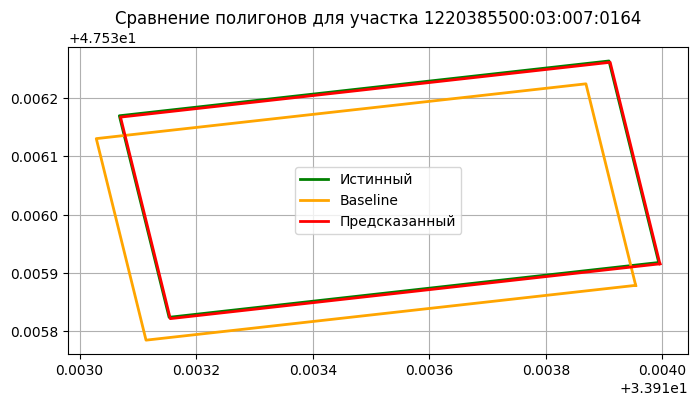

{'Расстояние от baseline-центра до истинного (м)': 6.18,
 'Расстояние от предсказанного центра до истинного (м)': 0.33,
 'IoU с baseline': 0.7401,
 'IoU с предсказанным': 0.9828}

In [ ]:
plot_polygon_comparison(
    number="1220385500:03:007:0164",
    df_points=df_points,
    df_predictions=df_predictions
)


In [5]:
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.affinity import translate
import pandas as pd
import numpy as np

def evaluate_polygon_predictions(df_points, df_predictions, df_centroids):
    """
    Анализирует точность предсказанных координат центроида:
    - Считает расстояния от baseline и предсказанного центра до истинного
    - Считает IoU между полигонами
    Возвращает DataFrame и сводную статистику по зонам
    """

    results = []

    for number in df_predictions["number"].unique():
        try:
            poly_df = df_points[df_points["number"] == number]
            if len(poly_df) < 3:
                continue  # слишком мало точек

            coords_true = list(zip(poly_df["wgs84_lon"], poly_df["wgs84_lat"]))
            poly_true = Polygon(coords_true)
            if not poly_true.is_valid:
                continue

            row = df_predictions[df_predictions["number"] == number].iloc[0]
            center_true = poly_true.centroid
            center_baseline = (
                row["wgs84_centroid_baseline_lon"],
                row["wgs84_centroid_baseline_lat"]
            )
            center_pred = (
                row["pred_lon"],
                row["pred_lat"]
            )

            # Сдвиги
            dx_baseline = center_baseline[0] - center_true.x
            dy_baseline = center_baseline[1] - center_true.y
            poly_baseline = translate(poly_true, xoff=dx_baseline, yoff=dy_baseline)

            dx_pred = center_pred[0] - center_true.x
            dy_pred = center_pred[1] - center_true.y
            poly_predicted = translate(poly_true, xoff=dx_pred, yoff=dy_pred)

            # Метрики
            dist_baseline = center_true.distance(Point(center_baseline)) * 111000
            dist_pred = center_true.distance(Point(center_pred)) * 111000
            iou_baseline = poly_true.intersection(poly_baseline).area / poly_true.union(poly_baseline).area
            iou_pred = poly_true.intersection(poly_predicted).area / poly_true.union(poly_predicted).area

            zone = df_centroids[df_centroids["number"] == number]["zone"].values[0] if number in df_centroids["number"].values else None

            results.append({
                "number": number,
                "zone": zone,
                "baseline_dist_m": round(dist_baseline, 4),
                "predicted_dist_m": round(dist_pred, 4),
                "iou_baseline": round(iou_baseline, 4),
                "iou_predicted": round(iou_pred, 4)
            })

        except Exception as e:
            print(f"❌ {number}: {e}")
            continue

    df_result = pd.DataFrame(results)

    return df_result


In [10]:

df_result = evaluate_polygon_predictions(df_points, df_predictions, df_centroids)

from IPython.display import display, HTML

# Оформляем красивый вывод
summary_named = df_result.groupby("zone")[["baseline_dist_m", "predicted_dist_m", "iou_baseline", "iou_predicted"]] \
    .agg(["mean", "median", "min", "max"]) \
    .round(4)

# Переименовываем колонки
summary_named.columns = [' '.join(col).strip() for col in summary_named.columns.values]
summary_named = summary_named.rename(columns={
    "baseline_dist_m mean": "Baseline distance to true (m)",
    "predicted_dist_m mean": "Predicted distance to true (m)",
    "iou_baseline mean": "IoU (baseline)",
    "iou_predicted mean": "IoU (prediction)"
})

# Сортировка по зоне
summary_named = summary_named.reset_index().sort_values("zone")

# Вывод
display(HTML("<h4>📊 Zone-wise comparison</h4>"))
display(HTML(summary_named.to_html(index=False)))



zone,Baseline distance to true (m),baseline_dist_m median,baseline_dist_m min,baseline_dist_m max,Predicted distance to true (m),predicted_dist_m median,predicted_dist_m min,predicted_dist_m max,IoU (baseline),iou_baseline median,iou_baseline min,iou_baseline max,IoU (prediction),iou_predicted median,iou_predicted min,iou_predicted max
1.0,13.7133,10.1396,2.9761,1423.5875,4.1417,0.2752,0.0037,1413.4440,0.5071,0.5337,0.0000,0.9554,0.9680,0.9878,0.0000,0.9999
2.0,10.4967,9.8951,8.5869,124.5868,1.1295,0.4121,0.0169,132.9757,0.6606,0.7265,0.0000,0.9503,0.9734,0.9882,0.0000,0.9989
3.0,7.9403,7.8482,6.8133,10.0583,0.7567,0.7556,0.0219,1.9889,0.8102,0.8468,0.3877,0.9675,0.9830,0.9894,0.8956,0.9993
4.0,9.6020,6.9113,5.6879,583.7594,3.1249,0.5914,0.0087,589.6435,0.7886,0.8557,0.0000,0.9819,0.9640,0.9890,0.0000,0.9999
5.0,7.0391,6.9150,5.7155,10.9217,0.5597,0.5139,0.0114,1.5182,0.7384,0.8882,0.0000,0.9602,0.8997,0.9932,0.0721,0.9999
6.0,6.6822,7.2312,5.1718,7.7587,0.9357,0.9892,0.4957,1.5843,0.9204,0.9410,0.7206,0.9747,0.9794,0.9893,0.9267,0.9948


In [7]:
df_result.head(10)

,number,zone,baseline_dist_m,predicted_dist_m,iou_baseline,iou_predicted
0,0520281400:01:004:0012,2.0,8.6444,0.3181,0.8553,0.9941
1,0520281400:02:003:0127,2.0,8.7750,0.1385,0.8131,0.9961
2,0520481300:03:001:0321,3.0,8.1236,0.2700,0.4053,0.9684
3,0520680800:01:003:0114,3.0,8.7270,0.2483,0.8736,0.9940
4,0520680800:01:005:0208,3.0,8.4736,0.4130,0.8478,0.9900
5,0520885400:02:003:0247,3.0,8.3600,0.0219,0.4200,0.9993
6,0521683300:03:000:0142,3.0,8.3910,0.8371,0.7851,0.9907
7,0522281400:05:000:0053,3.0,8.3459,0.7195,0.8575,0.9943
8,0522281400:05:000:0238,3.0,8.4729,0.5722,0.8701,0.9911
9,0522281400:05:000:1034,3.0,8.4554,0.7311,0.6852,0.9755


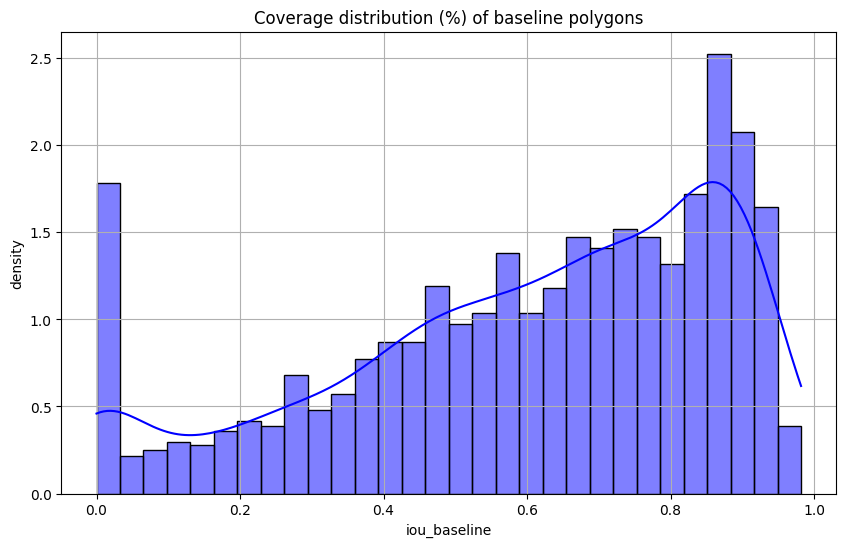

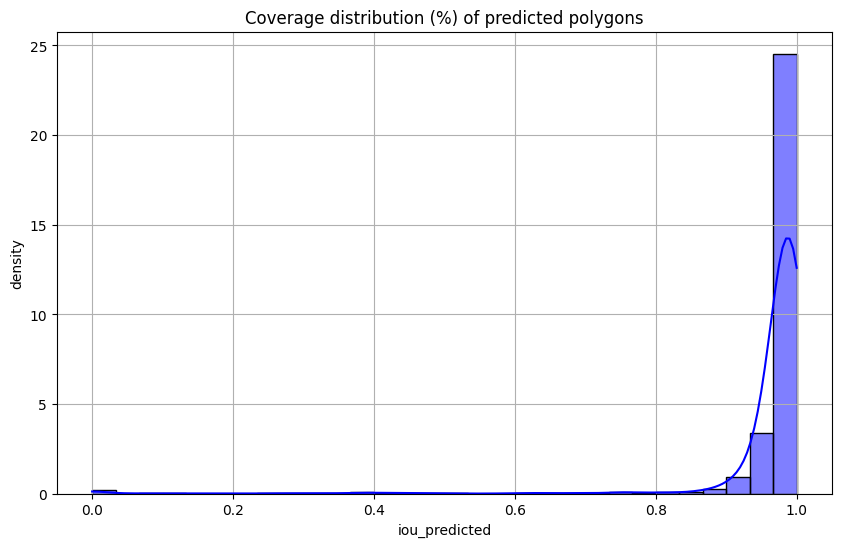

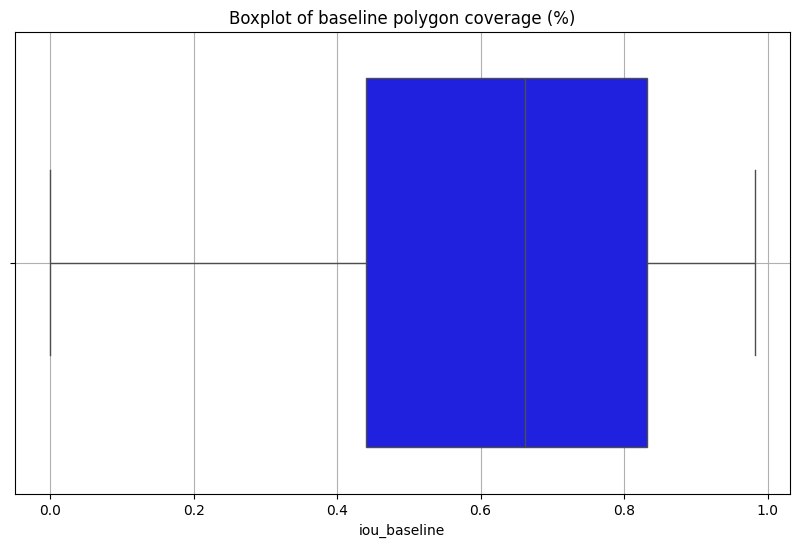

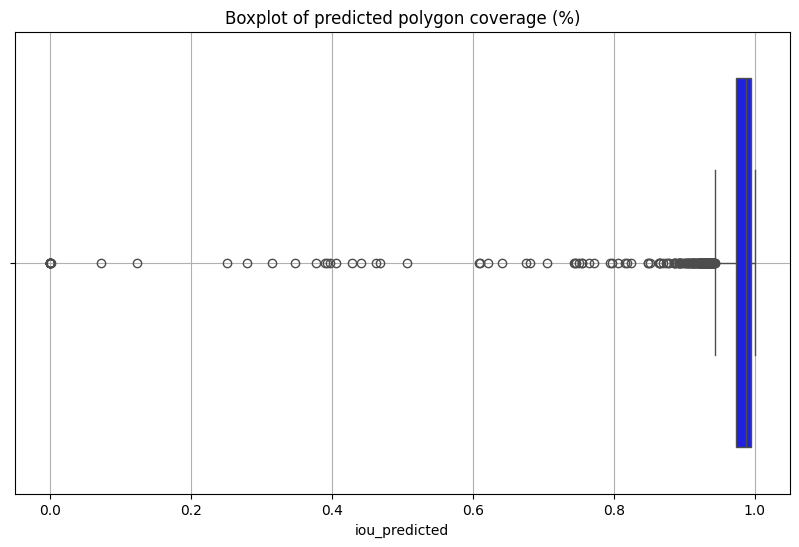

In [11]:
# распределение по точности предсказания
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(df, column, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=30, kde=True, color='blue', stat='density')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('density')
    plt.grid()
    plt.show()

def plot_boxplot(df, column, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column], color='blue')
    plt.title(title)
    plt.xlabel(column)
    plt.grid()
    plt.show()

plot_distribution(df_result, "iou_baseline", "Coverage distribution (%) of baseline polygons")
plot_distribution(df_result, "iou_predicted", "Coverage distribution (%) of predicted polygons")

plot_boxplot(df_result, "iou_baseline", "Boxplot of baseline polygon coverage (%)")
plot_boxplot(df_result, "iou_predicted", "Boxplot of predicted polygon coverage (%)")

In [26]:
df_result.describe()

,zone,baseline_dist_m,predicted_dist_m,iou_baseline,iou_predicted
count,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000
mean,1.883933,11.957555,3.156537,0.601792,0.968484
std,1.302288,48.105045,48.421683,0.267550,0.103876
min,1.000000,2.976100,0.008100,0.000000,0.000000
25%,1.000000,8.634600,0.177600,0.440000,0.975800
50%,1.000000,9.940000,0.338300,0.661200,0.988400
75%,3.000000,10.219200,0.637300,0.832400,0.994500
max,6.000000,1423.587500,1413.435800,0.981900,0.999800


In [29]:
96.85*0.1039


10.062715

In [ ]:
## 🔹 1. Загрузка predictions_MODEL.csv и points_processed.csv
## 🔹 2. Расчёт относительной ошибки
## 🔹 3. Расчёт площади и её влияние
## 🔹 4. Карты:
- heatmap ошибок
- карта участков > X км ошибки
- карта кластеров

## 🔹 5. Выявление аномалий:
- вырожденные участки
- участки с выбросами
- подозрительные регионы

## 🔹 6. Возврат в предыдущие этапы
